# Figure5

## Figure 5: Lipid concentration across different Lipid Classes

## Load External standard calibration file for Calibration

In [ ]:
library(dplyr)
library(readxl)
library(writexl)
library(openxlsx)
library(tidyverse)
library(pheatmap)
library(viridis)
library(ggplot2)
library(scales)

# Load the Excel file
file_path <- "ESTD-ALL-POS-NEG-CAL.xlsx"
df_std_cal <- read_excel(file_path, sheet = "Sheet1")

calculate_calibration_parameters <- function(row) {
  concentrations <- c(0)
  areas <- c(0)
  
  initial_concentration <- row[["Initial concentration"]]
  injection_columns <- c(names(row)[grep("^0_0", names(row))], 
                         unlist(lapply(1:7, function(i) paste0(i, "_", c(5, 1)))))
  
  for (col in injection_columns) {
    if (grepl("^0_0", col) || !is.na(row[[col]])) {
      if (grepl("^0_0", col)) {
        effective_concentration <- 0
        area <- 0
      } else {
        volume <- as.numeric(unlist(strsplit(col, "_"))[2])
        factor <- 1 / (2 ^ (as.numeric(unlist(strsplit(col, "_"))[1]) - 1))
        concentration <- initial_concentration * factor
        effective_concentration <- concentration * volume
        area <- row[[col]]
      }
      
      concentrations <- c(concentrations, effective_concentration)
      areas <- c(areas, area)
    }
  }
  
  data <- data.frame(concentrations = concentrations, areas = areas)
  model <- lm(areas ~ concentrations, data = data)
  slope <- coef(model)[2]
  intercept <- coef(model)[1]
  r_squared <- summary(model)$r.squared
  non_zero_concentrations <- concentrations[concentrations > 0 & areas > 0]
  LOD <- ifelse(length(non_zero_concentrations) > 0, min(non_zero_concentrations), NA)
  LOQ <- ifelse(!is.na(LOD), min(concentrations[concentrations >= 3 * LOD & areas > 0]), NA)
  if (is.na(LOQ)) {
    LOQ <- max(concentrations)
  }
  
  return(data.frame(
    Slope = slope,
    Intercept = intercept,
    `LOD (ng)` = LOD,
    `LOQ (ng)` = LOQ,
    `R²` = r_squared
  ))
}

calibration_params <- df_std_cal %>% 
  rowwise() %>% 
  do(calculate_calibration_parameters(.))
df_std_cal <- bind_cols(df_std_cal, calibration_params)

output_path <- "Fig5-ALL-updated.xlsx"
write_xlsx(df_std_cal, output_path)

# Calculate the concentration of the sample with peak area

In [ ]:
file_path <- "Fig5-ALL.xlsx"
df_ls_std <- read_excel(file_path, sheet = "LS-SIRIUS-STD")

file_path <- "Fig5-ALL-updated.xlsx"
data <- read_excel(file_path, sheet = "Sheet1")
colnames(data) <- trimws(colnames(data))

df_updated_ls_std_cal <- data %>%
  group_by(`Molecule List`, `Precursor Adduct`) %>%
  filter(R. == max(R.)) %>%
  ungroup()

merged_df <- df_ls_std %>%
  left_join(df_updated_ls_std_cal %>% select(`Molecule List`, `Precursor Adduct`, `Slope`, `Intercept`, `LOD..ng.`, `LOQ..ng.`), 
            by = c("Molecule List", "Precursor Adduct"))

merged_df <- merged_df %>%
  mutate(across(starts_with('Sum Total Area'), as.numeric),
         Slope = as.numeric(Slope),
         Intercept = as.numeric(Intercept))

sum_total_area_cols <- grep("Sum Total Area", names(merged_df), value = TRUE)

merged_df <- merged_df %>%
  mutate(across(all_of(sum_total_area_cols), 
                ~as.numeric(ifelse(.x %in% c("#N/A", "N/A", ""), NA, .x))))

concentration_columns <- sum_total_area_cols

for (col in concentration_columns) {
  concentration_col <- paste0(col, " Concentration")
  merged_df[[concentration_col]] <- (merged_df[[col]] - merged_df[["Intercept"]]) / merged_df[["Slope"]]
  
  above_loq_col <- paste0(concentration_col, " > LOQ")
  merged_df[[above_loq_col]] <- merged_df[[concentration_col]] > merged_df[["LOQ..ng."]]
}

write.xlsx(merged_df, "Fig5-ALL-concentration-updated.xlsx", sheetName = "SIRIUS-STD", rowNames = FALSE)

## Load the metadata to calculate Lipid concentration with treatment

In [ ]:
# Load the weight data
df_lipids <- data.frame(
  Sample = c(19, 22, 36, 28, 44, 49, 35, 40, 52, 27, 43, 48, 50),
  Type1 = c("Ambient", "Ambient", "Ambient", "Ambient", "Ambient", "Ambient", "Future", "Future", "Future", "Future", "Future", "Future", "Future"),
  Type2 = c("No_drought", "No_drought", "No_drought", "Drought", "Drought", "Drought", "No_drought", "No_drought", "No_drought", "Drought", "Drought", "Drought", "Drought"),
  Weight = c(2.054, 1.965, 2.063, 2.048, 2.063, 2.082, 2.065, 2.032, 2.033, 2.071, 2.028, 2.027, 0.178)
)

# Define the samples
samples <- c(19, 22, 36, 28, 44, 49, 35, 40, 52, 27, 43, 48, 50)

# Now use the samples in the regular expression
concentration_cols <- grep(paste(samples, collapse = "|"), grep('Sum Total Area Concentration', colnames(merged_df), value = TRUE), value = TRUE)


# Extract weights for the samples relevant to the concentration columns
sample_weights <- setNames(df_lipids$Weight[df_lipids$Sample %in% as.numeric(samples)], df_lipids$Sample[df_lipids$Sample %in% as.numeric(samples)])

# Define columns_containing_loq
columns_containing_loq <- grep("> LOQ", colnames(merged_df), value = TRUE)

# Now use the defined columns in the filter function
df <- merged_df %>%
  filter(!rowSums(is.na(select(., all_of(columns_containing_loq)))) & # Filter out rows with any NA values in LOQ columns
           !rowSums(select(., all_of(columns_containing_loq)) == 0)) %>%  # Filter out rows where LOQ columns are zero
  select(-all_of(columns_containing_loq)) %>%
  select(`Molecule List`, LipidMolecule, any_of(concentration_cols))

df <- df %>%
  group_by(`Molecule List`) %>%
  summarize(across(any_of(concentration_cols), sum, na.rm = TRUE))

# Exclude columns with "> LOQ" for normalization calculation
concentration_cols <- concentration_cols[!grepl("> LOQ", concentration_cols)]
print("Refined Concentration Columns:")

[1] "Refined Concentration Columns:"

 [1] "19 Sum Total Area Concentration" "22 Sum Total Area Concentration"
 [3] "27 Sum Total Area Concentration" "28 Sum Total Area Concentration"
 [5] "35 Sum Total Area Concentration" "36 Sum Total Area Concentration"
 [7] "40 Sum Total Area Concentration" "43 Sum Total Area Concentration"
 [9] "44 Sum Total Area Concentration" "48 Sum Total Area Concentration"
[11] "49 Sum Total Area Concentration" "52 Sum Total Area Concentration"

# A tibble: 6 × 13
# Rowwise: 
  `Molecule List` `19 Sum Total Area Concentration` 22 Sum Total Area Concentr…¹
  <chr>                                       <dbl>                        <dbl>
1 Cer                                       118.                         145.   
2 DG                                       2994.                        3319.   
3 DGDG                                      465.                         660.   
4 DGTS                                        5.48                         2.73 
5 HexCer                                     56.8                         66.6  
6 LPA                                         0.807                        0.628
# ℹ abbreviated name: ¹​`22 Sum Total Area Concentration`
# ℹ 10 more variables: `27 Sum Total Area Concentration` <dbl>,
#   `28 Sum Total Area Concentration` <dbl>,
#   `35 Sum Total Area Concentration` <dbl>,
#   `36 Sum Total Area Concentration` <dbl>,
#   `40 Sum Total Area Concentration` <dbl>,
#   `43 Sum Total A

[1] "Processed: 19 Sum Total Area Concentration"
[1] "Processed: 22 Sum Total Area Concentration"
[1] "Processed: 27 Sum Total Area Concentration"
[1] "Processed: 28 Sum Total Area Concentration"
[1] "Processed: 35 Sum Total Area Concentration"
[1] "Processed: 36 Sum Total Area Concentration"
[1] "Processed: 40 Sum Total Area Concentration"
[1] "Processed: 43 Sum Total Area Concentration"
[1] "Processed: 44 Sum Total Area Concentration"
[1] "Processed: 48 Sum Total Area Concentration"
[1] "Processed: 49 Sum Total Area Concentration"
[1] "Processed: 52 Sum Total Area Concentration"

# A tibble: 6 × 27
  `Molecule List` `19 Sum Total Area Concentration` 22 Sum Total Area Concentr…¹
  <chr>                                       <dbl>                        <dbl>
1 Cer                                       118.                         145.   
2 DG                                       2994.                        3319.   
3 DGDG                                      465.                         660.   
4 DGTS                                        5.48                         2.73 
5 HexCer                                     56.8                         66.6  
6 LPA                                         0.807                        0.628
# ℹ abbreviated name: ¹​`22 Sum Total Area Concentration`
# ℹ 24 more variables: `27 Sum Total Area Concentration` <dbl>,
#   `28 Sum Total Area Concentration` <dbl>,
#   `35 Sum Total Area Concentration` <dbl>,
#   `36 Sum Total Area Concentration` <dbl>,
#   `40 Sum Total Area Concentration` <dbl>,
#   `43 Sum Total Area Concentr

## Process Class list for plotting the Lipids across treatment

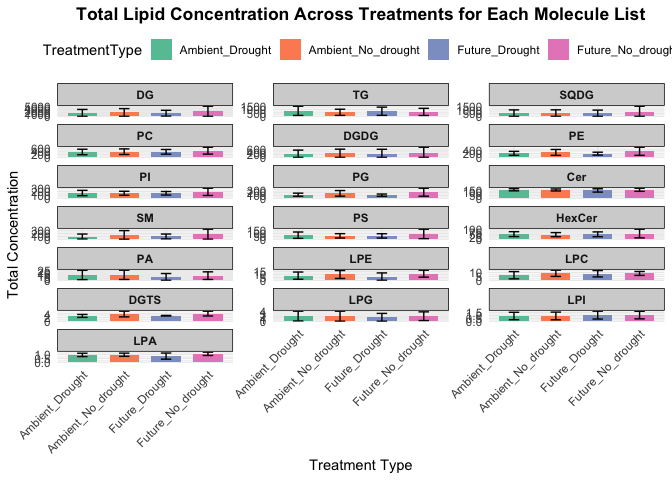

In [ ]:
process_molecule_list <- function(molecule_lists) {
  # Function to create a summarized dataframe for a specific treatment
  create_summary_df <- function(samples, treatment_name) {
    concentration_cols <- grep(paste(samples, collapse = "|"), grep('Sum Total Area Concentration', colnames(merged_df), value = TRUE), value = TRUE)
    
    df <- merged_df %>% 
      select(`Molecule List`, LipidMolecule, all_of(concentration_cols)) %>%
      group_by(`Molecule List`) %>%
      summarize(across(all_of(concentration_cols), sum, na.rm = TRUE)) %>%
      rowwise() %>%
      mutate(mean_concentration = mean(c_across(all_of(concentration_cols)), na.rm = TRUE),
             std_concentration = sd(c_across(all_of(concentration_cols)), na.rm = TRUE)) %>%
      ungroup()
    
    df$TreatmentType <- treatment_name
    return(df)
  }
  
  # Create summarized dataframes for each treatment
  ambient_no_drought_df <- create_summary_df(c('19', '22', '36'), 'Ambient_No_drought')
  future_no_drought_df <- create_summary_df(c('35', '40', '52'), 'Future_No_drought')
  ambient_drought_df <- create_summary_df(c('28', '44', '49'), 'Ambient_Drought')
  future_drought_df <- create_summary_df(c('27', '43', '48'), 'Future_Drought')
  
  # Combine all the summarized dataframes
  combined_df <- bind_rows(ambient_no_drought_df, future_no_drought_df, ambient_drought_df, future_drought_df)
  
  # Remove rows with NA mean_concentration
  combined_df <- combined_df %>% filter(!is.na(mean_concentration))
  
  # Check if there's any data left to plot
  if(nrow(combined_df) == 0) {
    warning("No valid data for any molecule list")
    return(NULL)
  }
  
  # Calculate total concentration for each Molecule List
  total_conc <- combined_df %>%
    group_by(`Molecule List`) %>%
    summarize(total_conc = sum(mean_concentration, na.rm = TRUE)) %>%
    arrange(desc(total_conc))
  
  # Order the Molecule List factor levels based on total concentration
  combined_df$`Molecule List` <- factor(combined_df$`Molecule List`, 
                                        levels = total_conc$`Molecule List`)
  
  # Create the plot
  p <- ggplot(combined_df, aes(x = TreatmentType, y = mean_concentration, fill = TreatmentType)) +
    geom_bar(stat = 'identity', position = position_dodge(), width = 0.7) +
    geom_errorbar(aes(ymin = pmax(mean_concentration - std_concentration, 0), 
                      ymax = mean_concentration + std_concentration),
                  position = position_dodge(0.7), width = 0.25) +
    facet_wrap(~ `Molecule List`, scales = "free_y", ncol = 3) +
    scale_fill_brewer(palette = "Set2") +
    labs(title = 'Total Lipid Concentration Across Treatments for Each Molecule List',
         x = 'Treatment Type', 
         y = 'Total Concentration') +
    theme_minimal() +
    theme(
      axis.text.x = element_text(angle = 45, hjust = 1),
      legend.position = "top",
      strip.background = element_rect(fill = "lightgrey"),
      strip.text = element_text(face = "bold"),
      plot.title = element_text(hjust = 0.5, face = "bold")
    )
  
  print(p)
  
  # Save the plot
  ggsave("all_molecule_lists_comparison_ordered.pdf", plot = p, width = 15, height = 12)
  
  # Return the combined dataframe
  return(combined_df)
}

# Get all unique Molecule List values
molecule_lists <- unique(merged_df$`Molecule List`)

# Process all Molecule Lists
results <- process_molecule_list(molecule_lists)